# Think Aloud: behavioral analysis

## Load data

In [48]:
import os
import copy
import pickle
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

OUTDATED_IGNORE=1

# participant info
result = pd.read_excel('participant_info.xlsx')

In [50]:
# load data
subjects = result['BIDS_ID']
sentencedata = list()
for i in range(len(subjects)):    
    sentencedata.append(pd.read_excel(os.path.join('behav_data', subjects[i] + '_transcripts.xlsx'),index_col=0))

In [52]:
# new dataframe with each row = thought
TR = 1.5

thoughtdata = list()
for i in range(len(sentencedata)):
    thoughtdata.append(sentencedata[i][['category','thoughtID']].groupby(['thoughtID']).mean().reset_index())
    df = sentencedata[i].groupby(['thoughtID'])['Transcribed Sentence'].apply(' '.join).reset_index()
    thoughtdata[i]['Transcribed Sentence'] = df['Transcribed Sentence']
    
    # add topic column
    df = sentencedata[i].groupby(['thoughtID'])['topic'].unique().apply(lambda x: x[0]).reset_index()
    thoughtdata[i]['topic'] = df['topic']
    
    # add start/end times of each thought
    starts = list()
    ends = list()
    starts_TR = list()
    ends_TR = list()
    for t in range(len(thoughtdata[i])):
        thisstart = sentencedata[i][sentencedata[i]['thoughtID']==t+1]['Start Time'].reset_index()
        thisend = sentencedata[i][sentencedata[i]['thoughtID']==t+1]['End Time'].reset_index()
        starts.append(thisstart['Start Time'][0])
        ends.append(thisend['End Time'][len(thisend)-1])
        starts_TR.append(round((thisstart['Start Time'][0])/TR))
        ends_TR.append(round((thisend['End Time'][len(thisend)-1])/TR))

    thoughtdata[i]['start_sec'] = starts
    thoughtdata[i]['end_sec'] = ends
    thoughtdata[i]['start_TR'] = starts_TR
    thoughtdata[i]['end_TR'] = ends_TR
    
    # add category/topic change columns
    thoughtdata[i]['category_change'] = np.empty((len(thoughtdata[i])))+np.nan
    thoughtdata[i]['category_change'][:-1] = thoughtdata[i]['category'][:-1].values != thoughtdata[i]['category'][1:].values
    thoughtdata[i]['topic_change'] = np.empty((len(thoughtdata[i])))+np.nan
    thoughtdata[i]['topic_change'][:-1] = thoughtdata[i]['topic'][:-1].values != thoughtdata[i]['topic'][1:].values
    thoughtdata[i]['category_change_only'] = (thoughtdata[i]['category_change'] == True) & (thoughtdata[i]['topic_change'] == False)
    thoughtdata[i]['topic_change_only'] = (thoughtdata[i]['category_change'] == False) & (thoughtdata[i]['topic_change'] == True)
    thoughtdata[i]['both_change'] = (thoughtdata[i]['category_change'] == True) & (thoughtdata[i]['topic_change'] == True)

## Thought content (topics)

In [29]:
# concatenate all subjects' data
for i, df in enumerate(thoughtdata):
    df['subjID'] = result['BIDS_ID'][i]
thoughtdata_concat = pd.concat(thoughtdata)

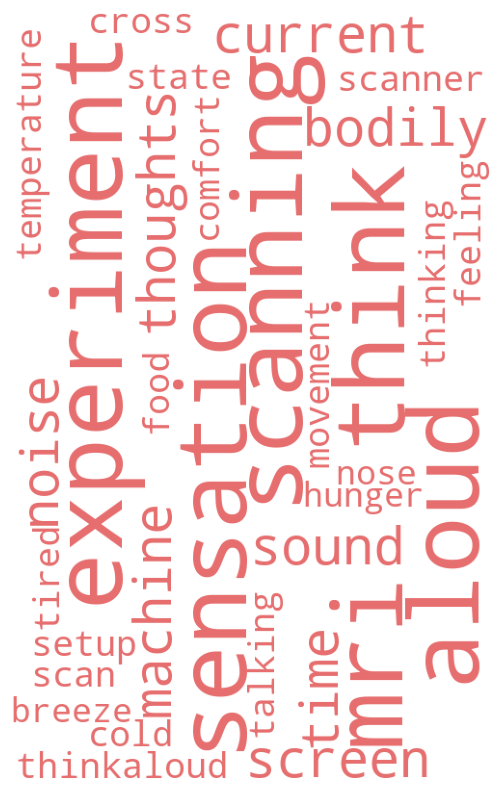

In [31]:
# current sensation
f, axes = plt.subplots(figsize=(10, 10));
wordcloud = WordCloud(relative_scaling=0,normalize_plurals=True,collocations=False,random_state=2,background_color='white', width=500, height=800, max_words=50, max_font_size=100, min_font_size=30, 
                      color_func=lambda *args, **kwargs: (230,110,110)).generate(', '.join(thoughtdata_concat[thoughtdata_concat['category']==1]['topic']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

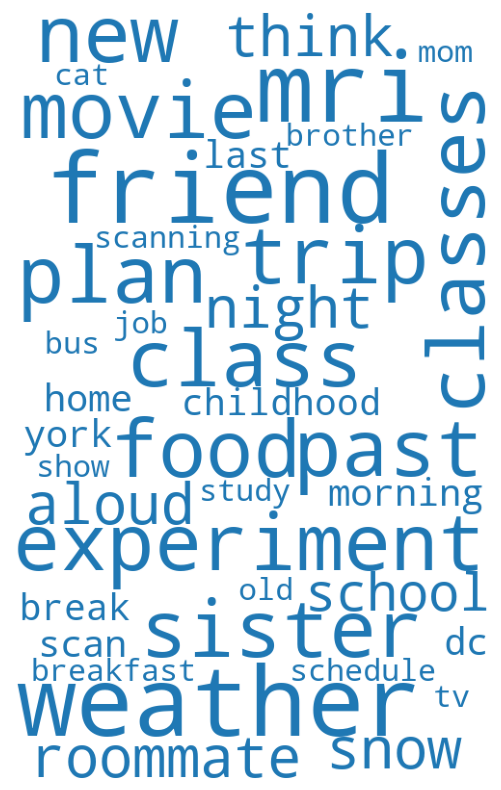

In [34]:
# episodic memory
f, axes = plt.subplots(figsize=(10, 10));
wordcloud = WordCloud(relative_scaling=0,normalize_plurals=True,collocations=False,random_state=7,background_color='white',width=500, height=800, max_words=50, max_font_size=100, min_font_size=30, color_func=lambda *args, **kwargs: "#1f78b4").generate(' '.join(thoughtdata_concat[thoughtdata_concat['category']==2]['topic']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

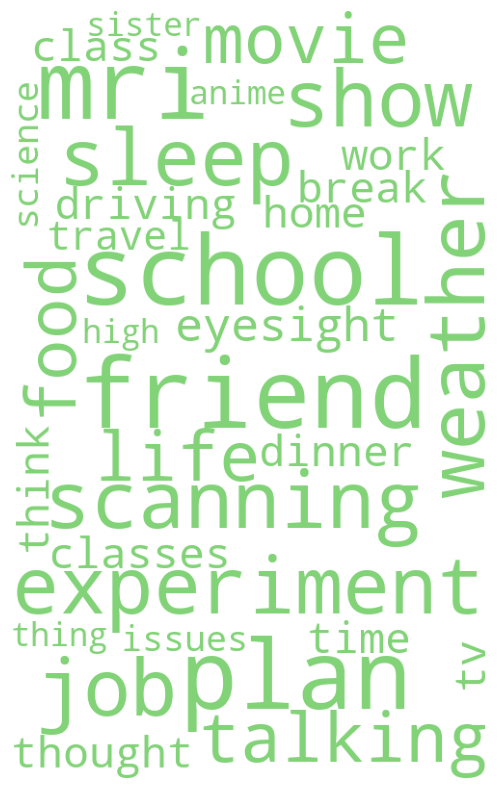

In [37]:
# semantic - self
f, axes = plt.subplots(figsize=(10, 10));
wordcloud = WordCloud(relative_scaling=0,normalize_plurals=True,collocations=False,random_state=8,background_color='white', width=500, height=800, max_words=50, max_font_size=100, min_font_size=30, color_func=lambda *args, **kwargs: (130,210,120)).generate(' '.join(thoughtdata_concat[thoughtdata_concat['category']==3]['topic']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

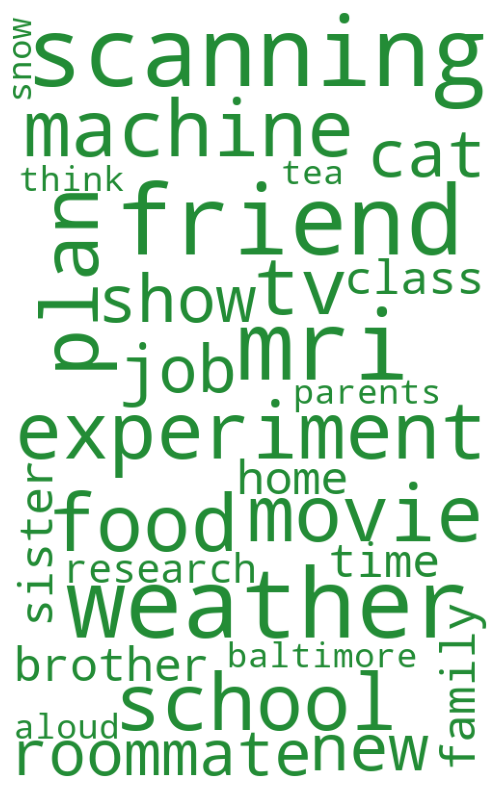

In [40]:
# semantic - world
f, axes = plt.subplots(figsize=(10, 10));
wordcloud = WordCloud(relative_scaling=0,normalize_plurals=True,collocations=False,random_state=9,background_color='white', width=500, height=800, max_words=50, max_font_size=100, min_font_size=30, color_func=lambda *args, **kwargs: (35,140,54)).generate(' '.join(thoughtdata_concat[thoughtdata_concat['category']==4]['topic']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

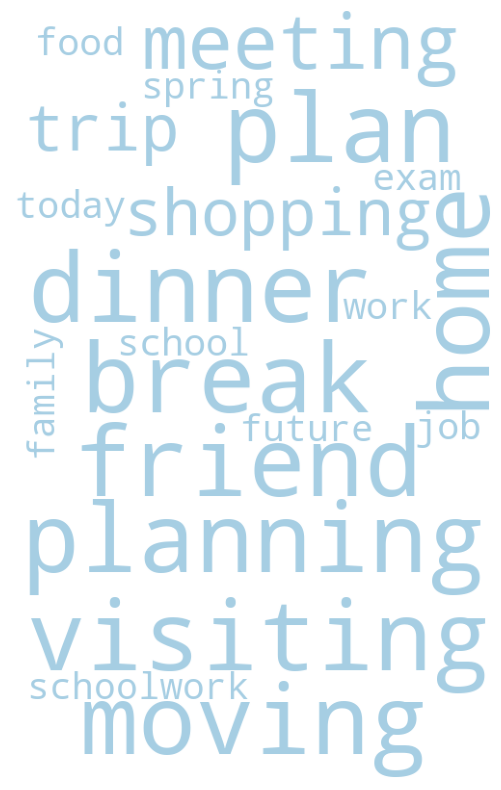

In [43]:
# future
f, axes = plt.subplots(figsize=(10, 10));
wordcloud = WordCloud(relative_scaling=0,normalize_plurals=True,collocations=False,random_state=6,background_color='white',width=500, height=800, max_words=50, max_font_size=100, min_font_size=30, color_func=lambda *args, **kwargs: (166,206,227)).generate(' '.join(thoughtdata_concat[thoughtdata_concat['category']==5]['topic']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Temporal distribution of thought categories

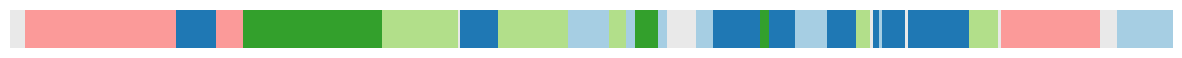

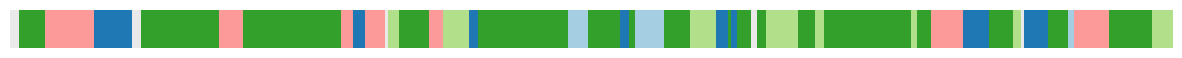

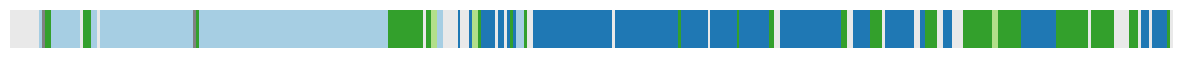

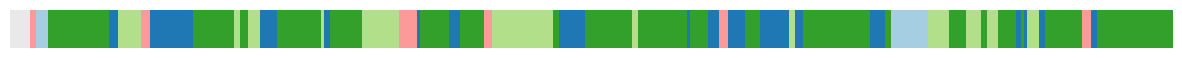

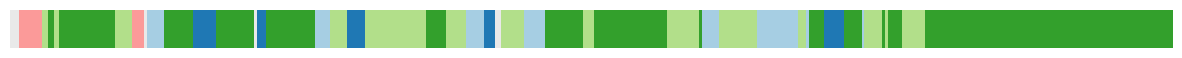

In [12]:
# thought category as a function of time (time zero = first real volume) - individual subjects
mycolors = ["#fb9a99", "#1f78b4", "#b2df8a", "#33a02c", "#a6cee3", "#808080","#e9e9e9"]
labels = ['current','episodic','semantic-self','semantic-world','future','other','filler/noresp']
scandur = 400 # time window = 1 TR

alltc = list()
for i in range(len(thoughtdata)):
    
    tc = np.zeros(scandur)+7 # 7=filler/no response
    
    for l in range(len(thoughtdata[i])): 
        tc[(thoughtdata[i]['start_TR'][l] - 1):thoughtdata[i]['end_TR'][l]] = thoughtdata[i]['category'][l]
        
    alltc.append(tc)    
    
    if i < 5:
        # individual subject plot
        f, ax = plt.subplots(figsize=(15, 0.5));
        sns.heatmap([tc], vmin=1, vmax=7, xticklabels=False, yticklabels=False, cbar=False, cmap=mycolors)

In [14]:
# concatenate all subjects
for i in range(len(alltc)):
    if i == 0:
        alltc_array = [alltc[i]] 
    else:
        alltc_array = np.concatenate((alltc_array,[alltc[i]]),axis=0)

# probabilities in each time point
for t in range(np.shape(alltc_array)[1]):
    df = pd.DataFrame(alltc_array[:,t]).value_counts(normalize=True, sort=False)
    
    prob = list()
    for c in (np.arange(7)+1):
        if c not in df.index:
            prob.append(0)
        else:
            prob.append(df[c]*100)
    
    if t == 0:
        allprob = [np.array(prob)]
    else:
        allprob = np.concatenate((allprob,[np.array(prob)]),axis=0)
        
allprob = pd.DataFrame(allprob, columns=labels).reset_index()
allprob['index'] = allprob['index']+1

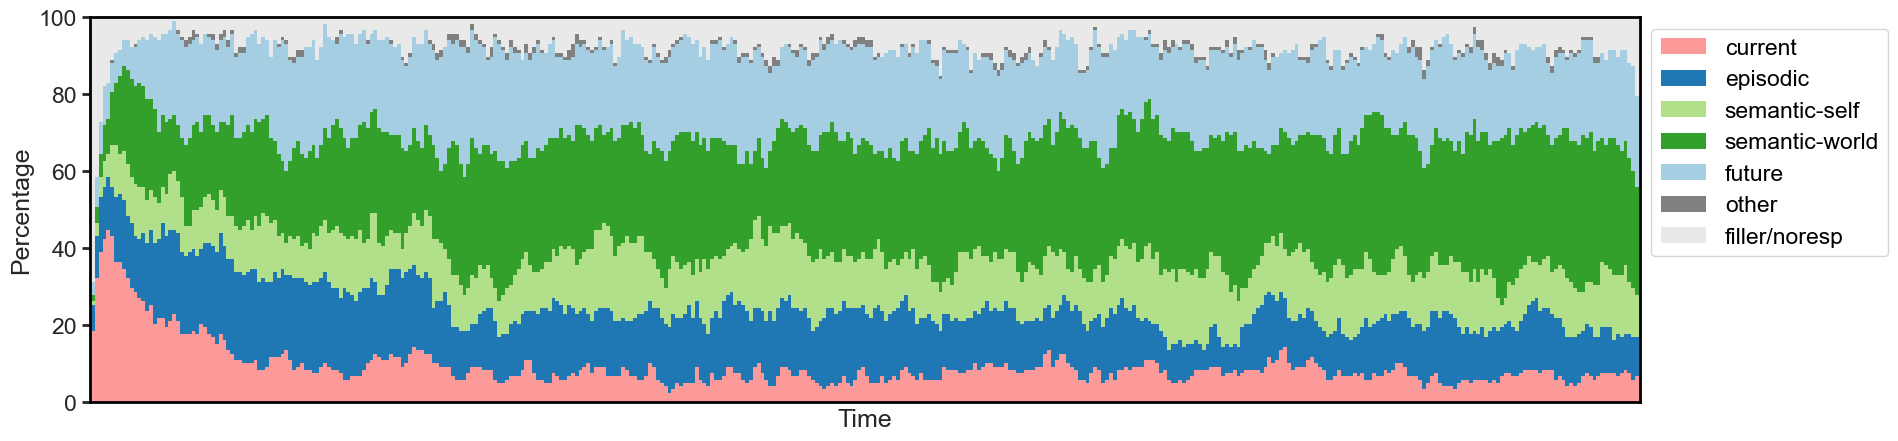

In [22]:
mycolormap = colors.ListedColormap(mycolors)
boundaries = np.arange(7)+1
norm = colors.BoundaryNorm(boundaries, mycolormap.N, clip=True)

sns.set_theme(style="ticks", font_scale=1.5, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5, "axes.linewidth": 2})

f, ax = plt.subplots(figsize=(20, 5));
allprob.plot( ax = ax, x = 'index', kind = 'bar', width = 1, stacked = True, colormap=mycolormap, linewidth=0) 
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.setp(ax, xticks=[], xticklabels=[], xlabel='Time', ylabel='Percentage', ylim=[0,100]);
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)  # Set the y-axis tick width

## Category percentages (excluding fillers)

In [15]:
ncat = 6 # number of thought categories

for c in range(ncat):
    result[('thoughtpercent_cat'+str(c+1))] = np.nan
    result[('percent_cat'+str(c+1))] = np.nan

for i in range(len(thoughtdata)):
    for c in range(ncat):
        # thought level
        result[('thoughtpercent_cat'+str(c+1))][i] = 100*len(thoughtdata[i][thoughtdata[i]['category']==(c+1)])/len(thoughtdata[i])
        # sentence level
        result[('percent_cat'+str(c+1))][i] = 100*len(sentencedata[i][sentencedata[i]['category']==(c+1)])/len(sentencedata[i])

In [32]:
# new (stacked) dataframes for plotting
subjects = list() 
categories = list()
percentages = list() 
for c in range(ncat):
    subjects = np.concatenate((subjects, np.arange(len(result))+1))
    categories = np.concatenate((categories, np.repeat(c+1, len(result)), ))
    percentages = np.concatenate((percentages, result[('thoughtpercent_cat'+str(c+1))].values))
    
longdf = pd.DataFrame({'subjects':subjects,'categories':categories,'percentages':percentages}) 

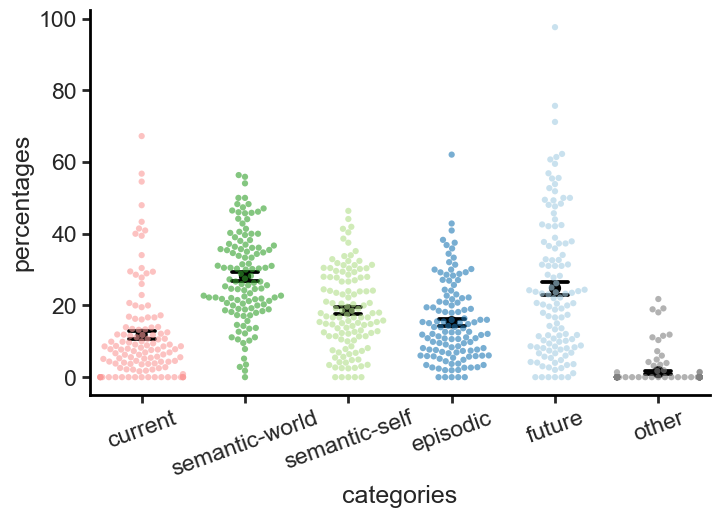

In [34]:
category_order = ['current','semantic-world','semantic-self','episodic','future','other']  
category_order_num = [1.0,4.0,3.0,2.0,5.0,6.0]
catcolors = ["#fb9a99", "#1f78b4", "#b2df8a", "#33a02c", "#a6cee3", "#808080"]

sns.set_theme(style="ticks", font_scale=1.5, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5, "axes.linewidth": 2,
                                                 "axes.spines.right": False, "axes.spines.top": False})

f, ax = plt.subplots(figsize=(8, 5))
sns.pointplot(x='categories', y='percentages', data=longdf, errorbar="se", capsize=.25, color="0", linestyles='', markers='o', order=category_order_num)
sns.swarmplot(x='categories', y='percentages', hue='categories', data=longdf, size=4.5, legend=False, palette=catcolors, edgecolor='none', alpha=0.6, order=category_order_num)
plt.xticks([0,1,2,3,4,5],category_order);
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)  # Set the y-axis tick width
ax.set_xticklabels(ax.get_xticklabels(),rotation = 20);

## Other thought descriptives

In [17]:
from collections import defaultdict

def count_consecutive_same_numbers(arr):
    counts = []
    current_number = arr[0]
    current_count = 1

    for i in range(1, len(arr)):
        if arr[i] == current_number:
            current_count += 1
        else:
            counts.append((current_number, current_count))
            current_number = arr[i]
            current_count = 1

    counts.append((current_number, current_count))  # Append the last sequence
    return counts

def compute_mean_consecutive_counts(counts):
    # Group counts by number
    number_groups = defaultdict(list)
    for number, count in counts:
        number_groups[number].append(count)

    # Compute mean for each number
    mean_counts = {number: sum(counts) / len(counts) for number, counts in number_groups.items()}
    return mean_counts

In [19]:
for c in range(ncat):
    result[('thoughtnumword_cat'+str(c+1))] = np.nan
for c in range(ncat):
    result[('thoughtdur_cat'+str(c+1))] = np.nan
for c in range(ncat):
    result[('thoughtworddensity_cat'+str(c+1))] = np.nan 
for c in range(ncat):
    result[('numstreak_cat'+str(c+1))] = np.nan
            
for i in range(len(thoughtdata)):
    
    numwords = list()
    duration = list()
    density = list()
    for l in range(len(thoughtdata[i])):
        numwords.append(len(thoughtdata[i]['Transcribed Sentence'][l].split()))
        duration.append(thoughtdata[i]['end_sec'][l]-thoughtdata[i]['start_sec'][l])
        density.append(numwords[l]/duration[l])
    
    thoughtdata[i]['numwords'] = numwords
    thoughtdata[i]['duration'] = duration
    thoughtdata[i]['density'] = density
    
    counts = count_consecutive_same_numbers(thoughtdata[i]['category'].to_numpy())
    mean_counts = compute_mean_consecutive_counts(counts)
    
    for c in range(ncat):
        if len(thoughtdata[i][thoughtdata[i]['category']==(c+1)]) > 0:
            # number of words per thought
            result[('thoughtnumword_cat'+str(c+1))][i] = thoughtdata[i][thoughtdata[i]['category']==(c+1)]['numwords'].mean()
            # duration in seconds per thought
            result[('thoughtdur_cat'+str(c+1))][i] = thoughtdata[i][thoughtdata[i]['category']==(c+1)]['duration'].mean()
            # speech rate per thought (word/sec)
            result[('thoughtworddensity_cat'+str(c+1))][i] = thoughtdata[i][thoughtdata[i]['category']==(c+1)]['density'].mean()
            # mean streak length
            result[('numstreak_cat'+str(c+1))][i] = mean_counts[c+1]

In [21]:
result.describe() # supplementary table 2

,age,drop_fmri_bin,Average clustering,thoughtpercent_cat1,percent_cat1,thoughtpercent_cat2,percent_cat2,thoughtpercent_cat3,percent_cat3,thoughtpercent_cat4,...,thoughtworddensity_cat3,thoughtworddensity_cat4,thoughtworddensity_cat5,thoughtworddensity_cat6,numstreak_cat1,numstreak_cat2,numstreak_cat3,numstreak_cat4,numstreak_cat5,numstreak_cat6
count,118.000000,43.0,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,118.000000,...,113.000000,117.000000,112.000000,20.000000,98.000000,113.000000,113.000000,117.000000,112.000000,20.000000
mean,23.355932,1.0,0.184167,11.781617,11.512886,15.325564,15.857935,18.619711,15.825847,28.078331,...,3.342154,2.981126,3.125161,3.835065,1.302489,1.245049,1.162477,1.251361,1.671005,1.010817
std,4.567678,0.0,0.049586,13.250119,13.938788,11.194505,13.742524,11.036439,11.153162,12.377568,...,0.766800,0.597313,0.920235,1.725733,0.448412,0.396889,0.226887,0.258187,1.876070,0.026557
min,18.000000,1.0,0.099211,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.122112,1.366010,1.521739,1.282051,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,20.000000,1.0,0.150656,3.604497,2.501203,6.932977,4.962871,11.379870,8.295957,20.000000,...,2.745510,2.550873,2.521977,2.827176,1.000000,1.000000,1.000000,1.083333,1.000000,1.000000
50%,23.000000,1.0,0.177791,7.864358,5.786705,12.650953,12.011539,17.170228,13.373984,26.666667,...,3.324344,2.917365,3.028958,3.605155,1.000000,1.062500,1.090909,1.200000,1.333333,1.000000
75%,25.000000,1.0,0.214592,13.904576,15.092562,21.567506,24.055407,27.777778,22.440183,36.300505,...,3.814354,3.398207,3.532974,4.693100,1.500000,1.333333,1.230769,1.333333,1.750000,1.000000
max,39.000000,1.0,0.383745,67.241379,71.250000,62.068966,60.000000,46.376812,54.867257,56.363636,...,5.573268,4.732009,7.349216,8.179810,2.625000,3.000000,2.133333,2.571429,20.500000,1.076923


## Thought category transition probability

In [63]:
def transition_matrix(transitions, n, d):
    M = [[0]*n for _ in range(n)]
    
    if d == 1:
        currentstate = transitions[:-1]
        transstate = transitions[1:]
    else:
        currentstate = transitions[1:]
        transstate = transitions[:-1]       
    
    for row in range(n):
        currentidx = [i for i in range(len(currentstate)) if currentstate[i] == (row+1)]
        
        for col in range(n):
            if len(currentidx) > 0: # state exists
                for j in range(len(currentidx)): 
                    if transstate[currentidx[j]] == (col+1):
                        M[row][col] += 1/len(currentidx)
            else:
                M[row][col] = np.nan
    return M

In [65]:
# transition probability matrices
for i in range(len(sentencedata)):
    if i == 0:
        category_array_sentence = transition_matrix(sentencedata[i]['category'].values, 6, 1)
    else:
        category_array_sentence = np.dstack((category_array_sentence, transition_matrix(sentencedata[i]['category'].values, 6, 1)))
        
# mean transition prob
category_array_sentence_mean = np.nanmean(category_array_sentence, axis=2)

In [67]:
# comparison against expected probability (subject-specific category percentage)
category_p_sentence = [[np.nan]*6 for _ in range(6)]
category_t_sentence = [[np.nan]*6 for _ in range(6)]
for row in range(6):
    for col in range(6):
        tresult = pg.ttest(category_array_sentence[row][col][~np.isnan(category_array_sentence[row][col][:])], 
                                 (result['percent_cat'+str(col+1)][~np.isnan(category_array_sentence[row][col][:])].values)/100, paired=True) 
        category_t_sentence[row][col] = tresult['T']['T-test']
        category_p_sentence[row][col] = tresult['p-val']['T-test']

In [69]:
# change the order of rows/columns
category_t_sentence_array = np.array(category_t_sentence)
category_t_sentence_array = category_t_sentence_array[[0,3,2,1,4,5],:]
category_t_sentence_array = category_t_sentence_array[:,[0,3,2,1,4,5]]

category_p_sentence_array = np.array(category_p_sentence)
category_p_sentence_array = category_p_sentence_array[[0,3,2,1,4,5],:]
category_p_sentence_array = category_p_sentence_array[:,[0,3,2,1,4,5]]

category_array_sentence_mean = category_array_sentence_mean[[0,3,2,1,4,5],:]
category_array_sentence_mean = category_array_sentence_mean[:,[0,3,2,1,4,5]]

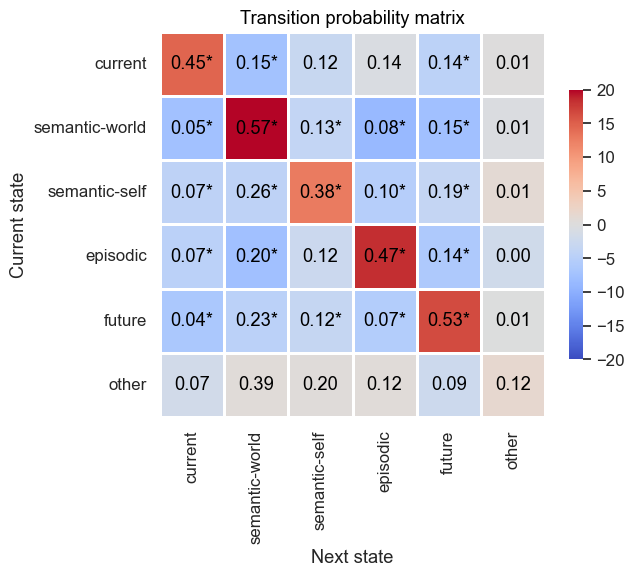

In [73]:
# plotting - all categories
category_order = ['current','semantic-world','semantic-self','episodic','future','other']  
category_order_num = [1.0,4.0,3.0,2.0,5.0,6.0]

sns.set_theme(style="white", font_scale=1.1, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5})
f, ax = plt.subplots(figsize=(6.3, 5));
a =sns.heatmap(category_t_sentence_array, annot=False, cmap='coolwarm', vmax=20, vmin=-20, square=True, linewidths=1, xticklabels=category_order, yticklabels=category_order, cbar_kws={"shrink": 0.7})

# Add custom annotations
pthres = 0.05/36 # Bonferroni corrected
for i in range(6):
    for j in range(6):
        value = round(category_array_sentence_mean[i][j],3)  # transition prob
        if category_p_sentence_array[i][j] < pthres:
            label = f"{value:.2f}*"
        else:
            label = f"{value:.2f}"
        plt.text(j + 0.5, i + 0.5, label, ha='center', va='center', color='black')
        
plt.title('Transition probability matrix');
ax.set(xlabel='Next state', ylabel='Current state');

## Semantic similarity between thoughts

In [16]:
# load thought-by-thought text embeddings
embdir = 'embeddings'

embeddings = list()
for index, row in result.iterrows():
    file = [file for file in os.listdir(embdir) if row['BIDS_ID'] in file]
    if len(file)==1:
        embeddings.append(pd.read_csv(os.path.join(embdir,file[0]), index_col=0))

In [24]:
# thought X thought sentence similarity matrices for each subject
from sklearn.metrics.pairwise import cosine_similarity

cosine_scores = list()
for i in range(len(embeddings)):
    cosine_scores.append(cosine_similarity(embeddings[i], embeddings[i]))

In [26]:
def extract_scores(thoughtdata, cosine_scores, category, wsize):
    
    allsubjw = list()
    
    for i in range(len(thoughtdata)):

        if category == -99:
            loc = thoughtdata[i].index
        else:
            loc = thoughtdata[i].index[thoughtdata[i]['category']==category]

        subjw = np.full((len(loc),wsize*2+1),np.nan)

        for j in range(len(loc)): # target thought category

            for w in range(wsize+1): # N thoughts before target
                if (loc[j]-w) > 0:
                    subjw[j,wsize-w] = cosine_scores[i][loc[j],loc[j]-w]
                else:
                    subjw[j,wsize-w] = np.nan

            for w in range(wsize+1): # N thoughts after target
                if (loc[j]+w) < len(thoughtdata[i]):
                    subjw[j,wsize+w] = cosine_scores[i][loc[j],loc[j]+w]
                else:
                    subjw[j,wsize+w] = np.nan

            subjw[j,wsize] = np.nan # target

        # average across thoughts
        allsubjw.append(np.nanmean(subjw, axis=0))

    return allsubjw

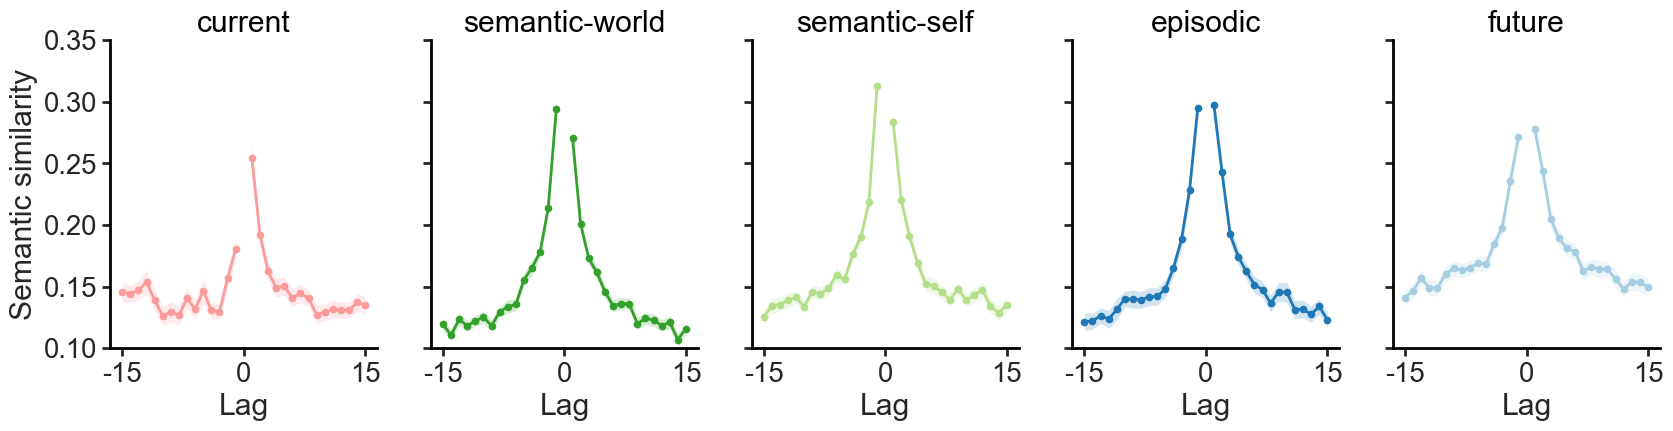

In [36]:
# all thought types excluding 'other'
wsize = 15
category_order = ['current','semantic-world','semantic-self','episodic','future','other']  
category_order_num = [1.0,4.0,3.0,2.0,5.0,6.0]

sns.set_theme(style="ticks", font_scale=1.8, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5, "axes.linewidth": 2,
                                                 "axes.spines.right": False, "axes.spines.top": False})
f, axes = plt.subplots(1, 5, figsize=(20, 4))
axesorder = [0,3,2,1,4]
catdf = list()
for i in range(5):
    
    category = i+1;
    
    # subject average
    catdf.append(pd.DataFrame(extract_scores(thoughtdata, cosine_scores, category, wsize)).reset_index())
    longdf = pd.melt(catdf[i], id_vars='index', value_vars=np.arange(wsize*2+1))
    longdf.columns = ['Subject','Lag','Semantic similarity']

    # plotting
    sns.lineplot(data=longdf[longdf['Lag'] < wsize], x='Lag', y='Semantic similarity', errorbar='se', marker= '.', markersize=11, linewidth=2, color=catcolors[i], ax=axes[axesorder[i]], err_kws={'linewidth':0})
    sns.lineplot(data=longdf[longdf['Lag'] > wsize], x='Lag', y='Semantic similarity', errorbar='se', marker= '.', markersize=11, linewidth=2, color=catcolors[i], ax=axes[axesorder[i]], err_kws={'linewidth':0})
    for line in axes[axesorder[i]].lines:
        line.set_markeredgewidth(0)
    axes[axesorder[i]].set(xticks=[0, wsize, wsize*2], xticklabels=[-wsize, 0, wsize], ylim=[0.1,.35], title=category_order[axesorder[i]]);
    axes[axesorder[i]].tick_params(axis='x', width=2)  # Set the x-axis tick width
    axes[axesorder[i]].tick_params(axis='y', width=2)  # Set the y-axis tick width
    
    if i > 0:
        axes[axesorder[i]].set(yticklabels=[ ], ylabel='');

## Thought boundaries

### Semantic similarity at thought boundaries

In [38]:
# semantic similarity between adjacent thoughts 
adj_similarity = []
for thismat in cosine_scores:
    adj_similarity.append([thismat[i, i+1] for i in range(thismat.shape[0]-1)])

In [40]:
# mean semantic similarity at different types of thought transitions
vars = ['category_change_only','both_change','topic_change_only']
meansimil = np.full([len(adj_similarity),len(vars)], np.nan)

for i in range(len(adj_similarity)):    
    for j in range(len(vars)):
        meansimil[i,j] = np.mean([adj_similarity[i][q] for q, val in enumerate(thoughtdata[i][:-1][vars[j]]) if val])
        
df = pd.DataFrame(meansimil,columns=vars) 

df.reset_index(inplace=True)
longdf = pd.melt(df[['index','category_change_only','both_change','topic_change_only']], 
                 id_vars='index', value_vars=['category_change_only','both_change','topic_change_only'])
longdf.columns = ['subjects','transition type','semantic similarity']

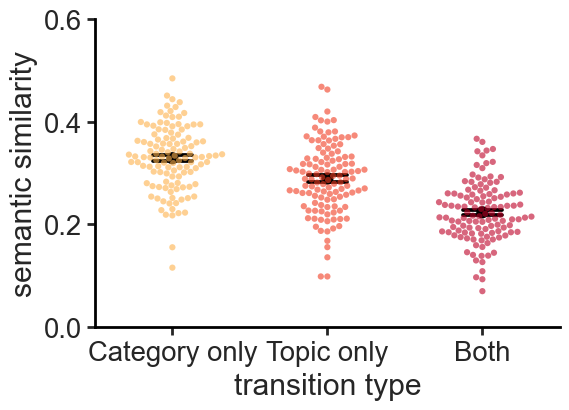

In [42]:
# plotting
transcolors = ["#feb24c", "#bd0026", "#f03b20"]
boundary_order = ['category_change_only','topic_change_only', 'both_change']
f, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(x='transition type', y='semantic similarity', data=longdf, errorbar="se", capsize=.25, color="0", linestyles='', markers='o', order=boundary_order)
sns.swarmplot(x='transition type', y='semantic similarity', hue='transition type', data=longdf, size=4.5, legend=False, palette=transcolors, edgecolor='none', alpha=0.6, order=boundary_order)
ax.set(xticklabels=['Category only','Topic only','Both'], ylim=[0, .6]);
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)  # Set the y-axis tick width

### Boundary agreement at thought boundaries

In [56]:
# boundary agreement (probabilty) for all thoughts
with open('boundary_agreement.pickcle', 'rb') as file:
    allsubj_boundary_data = pickle.load(file)
    
for i in range(len(thoughtdata)):                     
    idx = np.where(np.isin( round(allsubj_boundary_data[result['subjID'][i]]['sec_adj'],2),round(thoughtdata[i]['end_sec'],2)))[0]
    thoughtdata[i]['boundary_agreement'] = allsubj_boundary_data[result['subjID'][i]]['prob'][idx]

In [44]:
# mean boundary agreement at different types of boundaries 
catonly = list()
topiconly = list()
both = list()

for i in range(len(thoughtdata)):
    catonly.append(np.mean(thoughtdata[i][thoughtdata[i]['category_change_only']==True]['boundary_agreement']))
    topiconly.append(np.mean(thoughtdata[i][thoughtdata[i]['topic_change_only']==True]['boundary_agreement']))
    both.append(np.mean(thoughtdata[i][thoughtdata[i]['both_change']==True]['boundary_agreement']))
    
df = pd.DataFrame({'category_only': catonly, 'both': both, 'topic_only':topiconly})

df.reset_index(inplace=True)
longdf = pd.melt(df[['index','category_only','both','topic_only']], 
                 id_vars='index', value_vars=['category_only','both','topic_only'])
longdf.columns = ['subjects','transition_type','boundary_agreement']

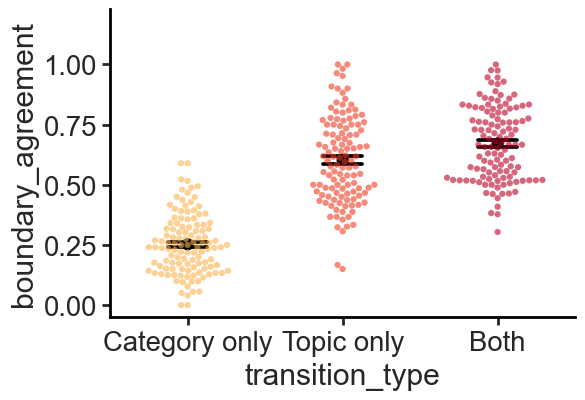

In [46]:
# plotting
boundary_order = ['category_only','topic_only', 'both']

f, ax = plt.subplots(figsize=(6, 4))
sns.pointplot(x='transition_type', y='boundary_agreement', data=longdf, errorbar="se", capsize=.25, color="0", linestyles='', markers='o', order=boundary_order)
sns.swarmplot(x='transition_type', y='boundary_agreement', hue='transition_type', data=longdf, size=4.5, legend=False, palette=transcolors, edgecolor='none', alpha=0.6, order=boundary_order)
ax.set(xticklabels=['Category only','Topic only','Both'], ylim=[-0.05, 1.23],yticks=[0,.25,.5,.75,1]);
ax.tick_params(axis='x', width=2)  # Set the x-axis tick width
ax.tick_params(axis='y', width=2)  # Set the y-axis tick width

#### Distribution of boundary agreements

In [58]:
# mean percentages (bins)

# Define bins
bins = np.arange(0, 1.1, 0.05).tolist() 
labels = list(map(str, bins[:-1]))

allsubj_agreement_freq = list()
for i in range(len(thoughtdata)):
    # Assign bin labels
    thoughtdata[i]['bin'] = pd.cut(thoughtdata[i]['boundary_agreement'], bins=bins, labels=labels, right=False)
    
    # mean frequency
    freq_counts = thoughtdata[i]['bin'].value_counts(normalize=False).reindex(labels).values
    allsubj_agreement_freq.append(freq_counts)    

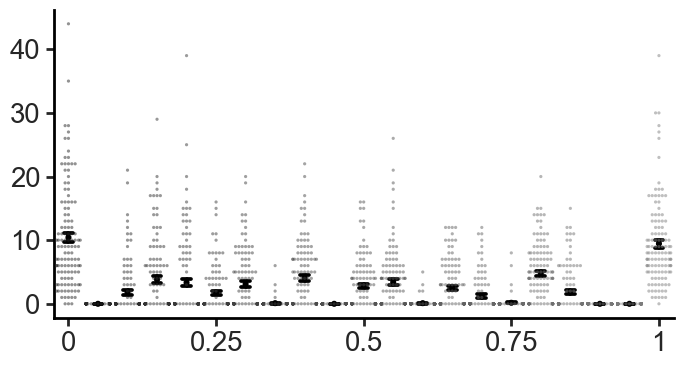

In [62]:
# frequency 
f, axes = plt.subplots(figsize=(8, 4));
sns.pointplot(data=np.array(allsubj_agreement_freq), errorbar="se", scale=0.5, capsize=.3, color="0", linestyles='', markers='o')
sns.swarmplot(data=np.array(allsubj_agreement_freq), size=2.3, legend=False, color=(.5,.5,.5), edgecolor='none', alpha=0.5)
axes.tick_params(axis='x', width=2)  # Set the x-axis tick width
axes.tick_params(axis='y', width=2)
axes.set(xticks=[0,5,10,15,20], xticklabels=[0,0.25,0.5,0.75,1]);

### Thought categories preceding/following strong thought boundaries 

In [54]:
# supplementary table 8

for i in range(len(thoughtdata)): 
    thoughtdata[i]['strong_boundary'] = thoughtdata[i]['boundary_agreement']==1
    thoughtdata[i]['strong_boundary'][len(thoughtdata[i])-1] = False
    
# percentage of pre/post category pairs
catpair_percent_allsubj = list()

for i in range(len(thoughtdata)): 
    
    strongboundaries = thoughtdata[i][thoughtdata[i]['strong_boundary']==True].reset_index()
    if len(strongboundaries) > 0:
        catpair_percent = [[0]*6 for _ in range(6)]
        for j in range(len(strongboundaries)):
            precat = int(thoughtdata[i]['category'][strongboundaries['index'][j]])
            if strongboundaries['index'][j]+1 < len(thoughtdata[i]): 
                postcat = int(thoughtdata[i]['category'][strongboundaries['index'][j]+1])
                catpair_percent[precat-1][postcat-1] = np.nansum([catpair_percent[precat-1][postcat-1], 1])   
        catpair_percent = 100*np.array(catpair_percent)/len(strongboundaries)
    else:
        catpair_percent = [[np.nan]*6 for _ in range(6)]
        
    catpair_percent_allsubj.append(catpair_percent)
    
catpair_percent_mean = np.nanmean(catpair_percent_allsubj, axis=0)
catpair_percent_std = np.nanstd(catpair_percent_allsubj, axis=0)

# change the order of rows/columns
catpair_percent_mean = catpair_percent_mean[[0,3,2,1,4,5],:]
catpair_percent_mean = catpair_percent_mean[:,[0,3,2,1,4,5]]
catpair_percent_std = catpair_percent_std[[0,3,2,1,4,5],:]
catpair_percent_std = catpair_percent_std[:,[0,3,2,1,4,5]]

In [103]:
catpair_percent_mean

array([[ 3.52785328,  2.55067326,  1.423642  ,  3.57937663,  3.65167163,
         0.05027652],
       [ 4.94743674,  6.34724687,  3.74210085,  4.93470143,  7.6023108 ,
         0.48365215],
       [ 4.09404082,  4.8954968 ,  3.08702851,  2.21607373,  3.99649231,
         0.21842355],
       [ 2.30875637,  2.54838528,  1.65195204,  2.4170541 ,  1.79192405,
         0.        ],
       [ 2.77991509,  6.03945265,  1.52969   ,  1.98131557, 15.0114699 ,
         0.18043685],
       [ 0.18043685,  0.13574661,  0.        ,  0.04748338,  0.04748338,
         0.        ]])

In [58]:
catpair_percent_std

array([[10.3372675 ,  7.20598106,  4.44429444, 10.81321012,  7.82900031,
         0.5414947 ],
       [ 8.50112931, 10.34543876,  8.24203108, 12.77580355, 13.83437447,
         2.36575403],
       [10.1382921 , 12.63392819,  8.6755358 ,  5.81390596,  7.99236439,
         1.38762006],
       [ 6.96952212, 10.02232435,  5.2993206 ,  6.86200115,  4.46730352,
         0.        ],
       [ 6.39722968, 10.70170617,  4.32075616,  5.17465382, 20.85163714,
         1.37015679],
       [ 1.37015679,  1.06396332,  0.        ,  0.51141166,  0.51141166,
         0.        ]])

## Semantic network analysis

In [72]:
# generate networks & figures

import networkx as nx
import nxviz as nv

def make_thought_networks(cosine_scores, thoughtdata, thr):
    
    edgeweights = copy.deepcopy(cosine_scores)
    networks = list()
    degrees = list()
    positions = list()
    clustering = list()
    for i in range(len(edgeweights)):

        # semantic similarity as edge weights
        edgeweights[i][np.triu_indices(np.size(edgeweights[i],1))] = 0
        edgeweights[i][edgeweights[i] < thr ] = 0

        # thought network
        networks.append(nx.from_numpy_array(edgeweights[i], create_using=nx.Graph()))

        # assign category for each node
        for j in range(len(thoughtdata[i])):
            networks[i].nodes[j]['category'] = thoughtdata[i]['category'][j]  
        
        # node degree centrality (normalized)
        degreeview = networks[i].degree(weight='weight')
        degrees.append([x[1]/(len(degreeview)-1) for x in degreeview])
        
        # network structure metric
        clustering.append(nx.average_clustering(networks[i], weight='weight',count_zeros=True))
        
        # node position for drawing
        positions.append(nx.spring_layout(networks[i], seed=10396953))
        
    return networks, degrees, positions, clustering

In [74]:
# minimal thresholding
networks, degrees, positions, clustering = make_thought_networks(cosine_scores, thoughtdata, 0)

# thresholded for visualization
networks_thr, degrees_thr, positions_thr, clustring_thr = make_thought_networks(cosine_scores, thoughtdata, .3)

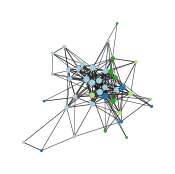

In [76]:
# draw a single network
i = 39 

edges = networks_thr[i].edges()
weights = [networks_thr[i][u][v]['weight'] for u,v in edges]
nodecolors = thoughtdata[i]['category'].apply(lambda x: catcolors[int(x)-1]).values
f, axes = plt.subplots(figsize=(2, 2));
nx.draw(networks_thr[i], pos=positions_thr[i], width=weights, node_color=nodecolors, node_size=[v * 50 for v in degrees_thr[i]])

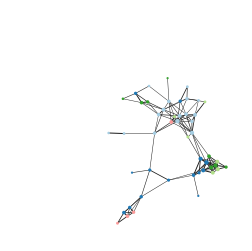

In [78]:
i = 115 

edges = networks_thr[i].edges()
weights = [networks_thr[i][u][v]['weight'] for u,v in edges]
nodecolors = thoughtdata[i]['category'].apply(lambda x: catcolors[int(x)-1]).values
f, axes = plt.subplots(figsize=(3, 3));
nx.draw(networks_thr[i], pos=positions_thr[i], width=weights, node_color=nodecolors, node_size=[v * 50 for v in degrees_thr[i]])

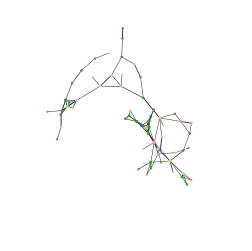

In [80]:
i = 86 

edges = networks_thr[i].edges()
weights = [networks_thr[i][u][v]['weight'] for u,v in edges]
nodecolors = thoughtdata[i]['category'].apply(lambda x: catcolors[int(x)-1]).values
f, axes = plt.subplots(figsize=(3, 3));
nx.draw(networks_thr[i], pos=positions_thr[i], width=weights, node_color=nodecolors, node_size=[v * 50 for v in degrees_thr[i]])

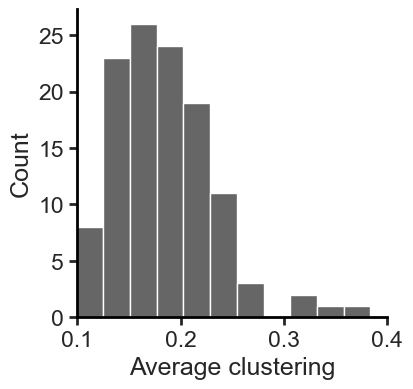

In [82]:
metrics = pd.DataFrame({'Average clustering': [s for s in clustering]})

sns.set_theme(style="ticks", font_scale=1.5, rc={"axes.edgecolor": "black", "text.color": "black", "lines.linewidth": 1.5, "axes.linewidth": 2,
                                                 "axes.spines.right": False, "axes.spines.top": False})
f, axes = plt.subplots(figsize=(4, 4));
sns.histplot(data = metrics['Average clustering'], color=(.2,.2,.2), legend=False);
axes.set(xlabel='Average clustering', xlim=[0.1, 0.4]); 
axes.tick_params(axis='x', width=2)  # Set the x-axis tick width
axes.tick_params(axis='y', width=2)